## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from datetime import date
today = date.today()

Using TensorFlow backend.


In [2]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [3]:
d1 = today.strftime("%m/%d/%y").replace(' 0', ' ')
d1

'05/19/20'

### Function to get the number of confirmed cases as a Dataframe

In [4]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew

### Function to get the number of deaths as a Dataframe

In [5]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new

### Function to get the number of recoveries as a Dataframe

In [6]:
def get_recovered():
    rec_new = pd.read_csv(confirmed_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new

### Scraper

In [7]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [8]:
numbers = get_newvals()
numbers

[4916995, 320564, 1922463]

## Forecasting Confirmed Cases

In [9]:
df = get_confirmed()

In [10]:
df.tail()

,Infected
5/14/20,4442163
5/15/20,4542347
5/16/20,4634068
5/17/20,4713620
5/18/20,4801943


In [11]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

cclose = close_data

In [12]:
look_back = 2

train_generator = TimeseriesGenerator(cclose, cclose, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 404ms/step - loss: 2709611095053.5571
Epoch 2/100
6/6 [==============================] - 0s 31ms/step - loss: 2674782434266.7979
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 2617536678062.6602
Epoch 4/100
6/6 [==============================] - 0s 29ms/step - loss: 2582349194329.5366
Epoch 5/100
6/6 [==============================] - 0s 27ms/step - loss: 2541669492636.6899
Epoch 6/100
6/6 [==============================] - 0s 21ms/step - loss: 2483775869943.8032
Epoch 7/100
6/6 [==============================] - 0s 26ms/step - loss: 2435065253906.6011
Epoch 8/100
6/6 [==============================] - 0s 20ms/step - loss: 2413007232524.6108
Epoch 9/100
6/6 [==============================] - 0s 22ms/step - loss: 2363131963866.4829
Epoch 10/100
6/6 [==============================] - 0s 29ms/step - loss: 2306577359381.7534
Epoch 11/100
6/6 [==============================] - 0s 23ms/step - loss: 2246099334602.4

6/6 [==============================] - 0s 11ms/step - loss: 1231785934.6404
Epoch 92/100
6/6 [==============================] - 0s 17ms/step - loss: 1221546588.0985
Epoch 93/100
6/6 [==============================] - 0s 19ms/step - loss: 1222752546.1084
Epoch 94/100
6/6 [==============================] - 0s 26ms/step - loss: 1220096928.7980
Epoch 95/100
6/6 [==============================] - 0s 25ms/step - loss: 1232561366.4828
Epoch 96/100
6/6 [==============================] - 0s 22ms/step - loss: 1231245483.2808
Epoch 97/100
6/6 [==============================] - 0s 29ms/step - loss: 1226520981.3990
Epoch 98/100
6/6 [==============================] - 0s 23ms/step - loss: 1224653642.9951
Epoch 99/100
6/6 [==============================] - 0s 22ms/step - loss: 1224065486.7094
Epoch 100/100
6/6 [==============================] - 0s 28ms/step - loss: 1226615783.6453


In [14]:
prediction = model.predict_generator(test_generator)

cclose = cclose.reshape((-1))
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [15]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)
forecast = numbers[0]

In [16]:
forecast

4916995

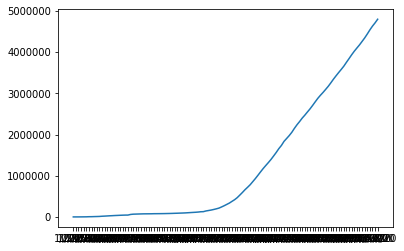

In [17]:
plt.plot(df)

In [18]:
df.tail()

,Infected
5/14/20,4442163
5/15/20,4542347
5/16/20,4634068
5/17/20,4713620
5/18/20,4801943


In [19]:
forecast

4916995

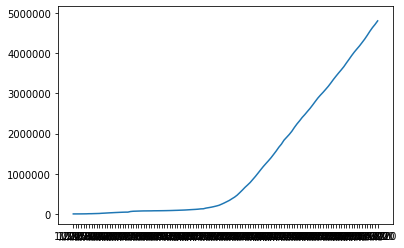

In [20]:
plt.plot(df)
plt.plot(forecast)

In [21]:
df_temp = df

In [22]:
df_temp.loc[d1] = forecast

In [23]:
df_temp

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
5/15/20,4542347
5/16/20,4634068
5/17/20,4713620
5/18/20,4801943
